# Machine learning on wine

**Topics:** Text analysis, linear regression, logistic regression, text analysis, classification

**Datasets**

- **wine-reviews.csv** Wine reviews scraped from https://www.winemag.com/
- **Data dictionary:** just go [here](https://www.winemag.com/buying-guide/tenuta-dellornellaia-2007-masseto-merlot-toscana/) and look at the page

## The background

You work in the **worst newsroom in the world**, and you've had a hard few weeks at work - a couple stories killed, a few scoops stolen out from under you. It's not going well.

And because things just can't get any worse: your boss shows up, carrying a huge binder. She slams it down on your desk.

"You know some machine learning stuff, right?"

You say "no," but she isn't listening. She's giving you an assignment, the _worst assignment_:

> Machine learning is the new maps. Let's get some hits!
>
> **Do some machine learning on this stuff.**

"This stuff" is wine reviews.

## A tiny, meagre bit of help

You have a dataset. It has some stuff in it:

* **Numbers:**
    - Year published
    - Alcohol percentage
    - Price
    - Score
    - Bottle size
* **Categories:**
    - Red vs white
    - Different countries
    - Importer
    - Designation
    - Taster
    - Variety
    - Winery
* **Free text:**
    - Wine description

# Cleaning up your data

Many of these pieces - the alcohol, the year produced, the bottle size, the country the wine is from - aren't in a format you can use. Convert the ones to numbers that are numbers, and extract the others from the appropriate strings.

In [125]:
import pandas as pd
import numpy as np
#some machine learning imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.stem.porter import PorterStemmer
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#some linear regression imports
import statistics
from statistics import mode
from statistics import median
import re
import statsmodels.api as sm

#some viz
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
sns.set(style='whitegrid',palette='husl')
matplotlib.rcParams['pdf.fonttype'] = 42

from tabulate import tabulate

%matplotlib inline 

In [68]:
df=pd.read_csv('wine-reviews.csv')

In [69]:
r = {'750 ml':750, '750ML':750, 
    '375 ml':375, '500 ml':500, '500ML':500,
     '1 L':1000, '1.5 L':1500,
       '375ML':375, '3 L':3000,
     '1.5L':1500, '1L':1000,
     '3L':3000, '187 ml':187}

df['bottle_size_ml'] = df['bottle size'].replace(r)
df.bottle_size_ml.value_counts() 

750     21055
375     237  
500     94   
3000    17   
1500    16   
1000    14   
187     2    
Name: bottle_size_ml, dtype: int64

In [70]:
 df['price_clean'] = df.price.str.split(',', expand=True)[0].str.replace('$', '').replace('N/A', np.nan).astype(float) 

In [71]:
 df['avg_rating_clean'] = df['user avg rating'].str[:2].replace('No', np.nan) 

In [72]:
 df['alcohol_clean'] = df.alcohol.str.replace('%', '').astype(float) 

In [73]:
 df['year'] = df.wine_name.str.extract(r'.*?(\d\d\d\d)').astype(float) 

In [74]:
df.sample(5)

,url,wine_points,wine_name,wine_desc,taster,price,designation,variety,appellation,winery,...,bottle size,category,importer,date published,user avg rating,bottle_size_ml,price_clean,avg_rating_clean,alcohol_clean,year
1594,https://www.winemag.com/buying-guide/louis-roederer-2002-cristal-rose-brut-champagne/,96.0,Louis Roederer 2002 Cristal Rosé Brut (Champagne),"Showing its age well, this wine offers a mature toastiness balanced by rich red fruit. The acidity is well integrated, making this impressive wine ready to drink now.",Roger Voss,"$800, Buy Now",Cristal Rosé Brut,"Champagne Blend, Sparkling","Champagne, Champagne, France",Louis Roederer,...,750 ml,Sparkling,Maisons Marques & Domaines USA,12/1/2018,Not rated yet [Add Your Review],750,800.0,NaN,12.0,2002.0
15228,https://www.winemag.com/buying-guide/odfjell-2010-orzada-carmenere-maule-valley/,88.0,Odfjell 2010 Orzada Carmenère (Maule Valley),"Massive and dark up front, with gritty aromas of herb, cola and black olive. It feels chunky, ripe and full bodied, bearing an herbal, minty flavor and notes of black fruit, licorice and earth. A chocolate/carob flavor marks the finish.",Michael Schachner,"$20, Buy Now",Orzada,Carmenère,"Maule Valley, Chile",Odfjell,...,750 ml,Red,Select Fine Wine Imports,9/1/2012,Not rated yet [Add Your Review],750,20.0,NaN,13.5,2010.0
15570,https://www.winemag.com/buying-guide/chateau-de-santenay-2014-les-pruliers-premier-cru-nuits-st-georges/,92.0,Château de Santenay 2014 Les Pruliers Premier Cru (Nuits-St.-Georges),"This structured wine is firm at this early stage, with tannins and a touch of bitter-chocolate extraction that needs to diminish before the black fruits get their chance. Keep this dark, solid wine until 2022.",Roger Voss,"$90, Buy Now",Les Pruliers Premier Cru,Pinot Noir,"Nuits-St.-Georges, Burgundy, France",Château de Santenay,...,750 ml,Red,The Bright Raven,10/1/2016,Not rated yet [Add Your Review],750,90.0,NaN,13.0,2014.0
509,https://www.winemag.com/buying-guide/fetzer-2000-eagle-peak-merlot-other/,86.0,Fetzer 2000 Eagle Peak Merlot (California),"Black cherry flavors mark this pretty wine, which also has a distinctive herbal edge. The tannins are soft, but good acidity keeps it lively in the mouth, and it finishes clean, fruity and spicy. Nice everyday drinking at a great price. Best Buy.",NaN,"$9, Buy Now",Eagle Peak,Merlot,"California, California Other, California, US",Fetzer,...,750 ml,Red,NaN,6/1/2002,Not rated yet [Add Your Review],750,9.0,NaN,13.5,2000.0
9612,https://www.winemag.com/buying-guide/hacienda-1999-clair-lune-cabernet-sauvignon-other/,83.0,Hacienda 1999 Clair de Lune Cabernet Sauvignon (California),"Starts with rustic, earthy-berry aromas with some green notes, then turns simple and lightly fruity in the mouth. Soft acids and dry tannins help this wine finish clean and scouring.",NaN,"$7, Buy Now",Clair de Lune,Cabernet Sauvignon,"California, California Other, California, US",Hacienda,...,750ML,Red,NaN,11/1/2002,Not rated yet [Add Your Review],750,7.0,NaN,12.5,1999.0


In [75]:
pd.set_option('display.max_colwidth', -1)

In [76]:
# for i, v in zip(df.loc[df['year']<1900,'year'].index, df.loc[df['year']<1900,'year'].values):
#     df.loc[i,'year']=df[df['year']<1900].wine_name.str.extract(r'.*?\d\d\d\d.*?(\d\d\d\d)',expand=False).astype(float)[i]

In [77]:
# change the values less than 1900
df.loc[df['year']<1900,'year']=df[df['year']<1900].wine_name.str.extract(r'.*?\d\d\d\d.*?(\d\d\d\d)',expand=False).astype(float)

In [78]:
df.loc[df['year']<1900,'year']

Series([], Name: year, dtype: float64)

In [ ]:
df[df['year']<1900].wine_name.str.extract(r'.*?\d\d\d\d.*?(\d\d\d\d)',expand=False).astype(float)[i]

In [64]:
 df.loc[2340,'year']

2009.0

In [60]:
df[df['year']<1900].wine_name.str.extract(r'.*?\d\d\d\d.*?(\d\d\d\d)',expand=False).astype(float)

141      2016.0
2340     2009.0
3474    NaN    
4917     2002.0
7323     2015.0
9386     2007.0
10238   NaN    
10689    2011.0
11327    2007.0
11589   NaN    
16708    2012.0
17775    2014.0
18115    2014.0
21151    2011.0
Name: wine_name, dtype: float64

In [83]:
df['appellation_clean'] = df.appellation.str.extract('(\w*.)$').astype(str)

## What might be interesting in this dataset?

Maybe start out playing around _without_ machine learning. Here are some thoughts to get you started:

* I've heard that since the 90's wine has gone through [Parkerization](https://www.estatewinebrokers.com/blog/the-parkerization-of-wine-in-the-1990s-and-beyond/), an increase in production of high-alcohol, fruity red wines thanks to the influence of wine critic Robert Parker.
* Red and white wines taste different, obviously, but people always use [goofy words to describe them](https://winefolly.com/tutorial/40-wine-descriptions/)
* Once upon a time in 1976 [California wines proved themselves against France](https://en.wikipedia.org/wiki/Judgment_of_Paris_(wine)) and France got very angry about it

In [89]:
df.head()

,url,wine_points,wine_name,wine_desc,taster,price,designation,variety,appellation,winery,...,category,importer,date published,user avg rating,bottle_size_ml,price_clean,avg_rating_clean,alcohol_clean,year,appellation_clean
0,https://www.winemag.com/buying-guide/artadi-2011-vinas-gain-tempranillo-rioja/,90.0,Artadi 2011 Viñas de Gain (Rioja),"Inky, minerally aromas of blackberry, black plum and coconut filter into a round, fluffy palate that's friendly and pure but not very dense or structured. Baked flavors of molasses and gamy berry finish mild and easy.",Michael Schachner,"$25, Buy Now",Viñas de Gain,Tempranillo,"Rioja, Northern Spain, Spain",Artadi,...,Red,Folio Fine Wine Partners,12/1/2014,Not rated yet [Add Your Review],750,25.0,NaN,14.5,2011.0,Spain
1,https://www.winemag.com/buying-guide/adelsheim-2012-stoller-vineyard-chardonnay-willamette-valley-dundee-hills/,90.0,Adelsheim 2012 Stoller Vineyard Chardonnay (Dundee Hills),"A tiny production wine, this is rich, tart and vividly fruity. The generous mix of citrus, apple and peach fruit is augmented by barrel fermentation flavors of toasted hazelnuts, caramel and baking spices. Though made with traditional Burgundian techniques, the flavors are New Worldly, bright and fruit-driven.",Paul Gregutt,"$65, Buy Now",Stoller Vineyard,Chardonnay,"Dundee Hills, Willamette Valley, Oregon, US",Adelsheim,...,White,NaN,12/1/2014,Not rated yet [Add Your Review],750,65.0,NaN,13.5,2012.0,US
2,https://www.winemag.com/buying-guide/adelsheim-2013-ribbon-springs-vineyard-other-white-auxerrois-willamette-valley-ribbon-ridge/,90.0,Adelsheim 2013 Ribbon Springs Vineyard Auxerrois (Ribbon Ridge),"This is another fine vintage for this rare wine. It's loaded with cool climate, mineral-laced scents of grapefruit, kiwi and melon. A whiff of fennel adds further interest. Super refreshing and a nice change from the ordinary sipping whites.",Paul Gregutt,"$25, Buy Now",Ribbon Springs Vineyard,"Auxerrois, Other White","Ribbon Ridge, Willamette Valley, Oregon, US",Adelsheim,...,White,NaN,12/1/2014,Not rated yet [Add Your Review],750,25.0,NaN,13.5,2013.0,US
3,https://www.winemag.com/buying-guide/jcb-2011-no-11-pinot-noir-sonoma-coast/,90.0,JCB 2011 No. 11 Pinot Noir (Sonoma Coast),"Light in color and lilting floral aromas of rose, this is an inviting cool-climate Pinot Noir swirling in equal parts strawberry and spice, subtle and sophisticated.",Virginie Boone,"$65, Buy Now",No. 11,Pinot Noir,"Sonoma Coast, Sonoma, California, US",JCB,...,Red,NaN,12/1/2014,Not rated yet [Add Your Review],750,65.0,NaN,13.0,2011.0,US
4,https://www.winemag.com/buying-guide/pazo-pondal-2013-albarino-rias-baixas/,90.0,Pazo Pondal 2013 Albariño (Rías Baixas),"Alluring, inviting aromas of white flowers, melon and peach are pure as stream water. This feels round and juicy, with flavors of green herbs, lettuce, lime and orange. Tangerine notes carry the finish, which is linear and racy in feel before turning slightly pithy in flavor.",Michael Schachner,"$17, Buy Now",NaN,Albariño,"Rías Baixas, Galicia, Spain",Pazo Pondal,...,White,Vinaio Imports,12/1/2014,Not rated yet [Add Your Review],750,17.0,NaN,13.0,2013.0,Spain


## But machine learning?

Well, you can usually break machine learning down into a few different things. These aren't necessarily perfect ways of categorizing things, but eh, close enough.

* **Predicting a number**
    - Linear regression
    - How does a change in unemployment translate into a change in life expectancy?
* **Predicting a category** (aka classification)
    - Lots of algos options: logistic regression, random forest, etc
    - For example, predicting cuisines based on ingredients
* **Seeing what influences a numeric outcome**
    - Linear regression since the output is a number
    - For example, minority and poverty status on test scores 
* **Seeing what influences a categorical outcome**
    - Logistic regression since the output is a category
    - Race and car speed for if you get a waring vs ticket
    - Wet/dry pavement and car weight if you survive or not in a car crash)

We have numbers, we have categories, we have all sorts of stuff. **What are some ways we can mash them together and use machine learning?**

### Brainstorm some ideas

Use the categories above to try to come up with some ideas. Be sure to scroll up where I break down categories vs numbers vs text!

**I'll give you one idea for free:** if you don't have any ideas, start off by creating a classifier that determines whether a wine is white or red based on the wine's description.

In [ ]:
# wine description --> taster (i don't think i have enough tasters)
# wine description --> country
# year --> price

You can also go to https://library.columbia.edu and see if you can find some academic papers about wine. I'm sure they'll inspire you! (and they might even have some ML ideas in them you can steal, too)

# Implement 2 of your machine learning ideas

# Predicting Whether Wine is White

In [97]:
#vectorize the description using a vectorizer
df=df[df['wine_desc'].isnull()==False]


<21313x17088 sparse matrix of type '<class 'numpy.int64'>'
	with 756142 stored elements in Compressed Sparse Row format>

In [98]:
words_df = pd.DataFrame(X.toarray(), columns=count_vectorizer.get_feature_names())

In [99]:
words_df.head()

,000,002,01,01s,02,02s,03,030,04,04s,...,zweigelt,zwerithaler,zwiegelt,zéro,½seasoningï,½t,émilion,über,überbest,ürziger
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
# count how many times each word is used

In [101]:
words_df.sum().sort_values(ascending=False).head(10)

and        58001
the        39430
of         27761
with       21079
this       17275
is         16802
it         14855
wine       13886
in         10954
flavors    10931
dtype: int64

In [ ]:
#build features

In [102]:
df['is_white'] = np.where(df['category'] == 'White', 1,0)

In [103]:
df.is_white.value_counts()

0    15256
1    6057 
Name: is_white, dtype: int64

In [104]:
X = words_df
y = df['is_white']


In [108]:
#test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [109]:
clf = DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X_train, y_train)
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [111]:
y_true = y_test
y_pred = clf.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['not white wine', 'white wine'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names)

,Predicted not white wine,Predicted white wine
Is not white wine,2644,1200
Is white wine,45,1440


In [112]:
feature_names = X.columns
importances = clf.feature_importances_

pd.DataFrame({
    'feature': feature_names,
    'feature importance': importances,
}).sort_values(by='feature importance', ascending=False)

,feature,feature importance
15050,tannins,0.298983
2993,cherry,0.264948
1805,black,0.161715
1707,berry,0.143696
12256,red,0.112612
16985,yellow,0.002889
1004,apricot,0.002436
10966,pear,0.001825
12625,riesling,0.001800
2912,chard,0.001631


In [114]:
# use a TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=2000)
vectors = vectorizer.fit_transform(df.wine_desc)
words_df = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names())
words_df.head()

,000,05,10,100,11,12,13,14,15,16,...,your,youth,youthful,zest,zestiness,zesty,zin,zinfandel,zingy,zippy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
X = words_df
y = df['is_white']


In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [117]:
clf = DecisionTreeClassifier(max_depth=10)
clf = clf.fit(X_train, y_train)
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [118]:
y_true = y_test
y_pred = clf.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(['not white wine', 'white wine'])
pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names)

,Predicted not white wine,Predicted white wine
Is not white wine,3048,806
Is white wine,33,1442


In [119]:
feature_names = X.columns
importances = clf.feature_importances_

pd.DataFrame({
    'feature': feature_names,
    'feature importance': importances,
}).sort_values(by='feature importance', ascending=False)

,feature,feature importance
1761,tannins,0.203581
356,cherry,0.183933
228,black,0.113761
218,berry,0.099209
1432,red,0.080209
230,blackberry,0.072698
355,cherries,0.065519
1423,raspberry,0.057074
303,cabernet,0.038329
1694,strawberry,0.037734


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21313 entries, 0 to 21434
Data columns (total 23 columns):
url                  21313 non-null object
wine_points          21313 non-null float64
wine_name            21313 non-null object
wine_desc            21313 non-null object
taster               15270 non-null object
price                21313 non-null object
designation          15550 non-null object
variety              21313 non-null object
appellation          21313 non-null object
winery               21313 non-null object
alcohol              17737 non-null object
bottle size          21313 non-null object
category             21313 non-null object
importer             11711 non-null object
date published       21313 non-null object
user avg rating      21313 non-null object
bottle_size_ml       21313 non-null int64
price_clean          19753 non-null float64
avg_rating_clean     8 non-null object
alcohol_clean        17737 non-null float64
year                 20583 non-nu

# Linear Regression on Wine Year and Price

In [136]:
#750 ml is the standard bottle
df['price_per_bottle']=df['price_clean']/df['bottle_size_ml']*750

In [137]:
X = sm.add_constant(df['year'])
mod = sm.OLS(df['price_per_bottle'], X, missing='drop')
res = mod.fit()
res.summary()

/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       price_per_bottle   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     148.0
Date:                Wed, 07 Aug 2019   Prob (F-statistic):           6.42e-34
Time:                        14:58:11   Log-Likelihood:            -1.0414e+05
No. Observations:               19110   AIC:                         2.083e+05
Df Residuals:                   19108   BIC:                         2.083e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2075.9102    167.265     12.411      0.000    1748.056    2403.765
year          -1.0130      0.083    -12.164      0.000      -1.176      -0.850
==============================================================================
Omnibus:                    34735.640   Durbin-Watson:                   1.362
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         94481671.566
Skew:                          13.139   Prob(JB):                         0.00
Kurtosis:                     346.464   Cond. No.                     8.25e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.25e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

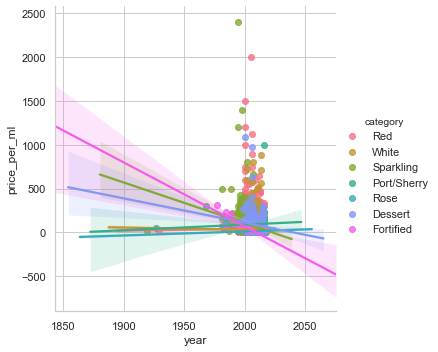

In [138]:
sns.lmplot(data=df,x='year',y='price_per_ml',hue='category')